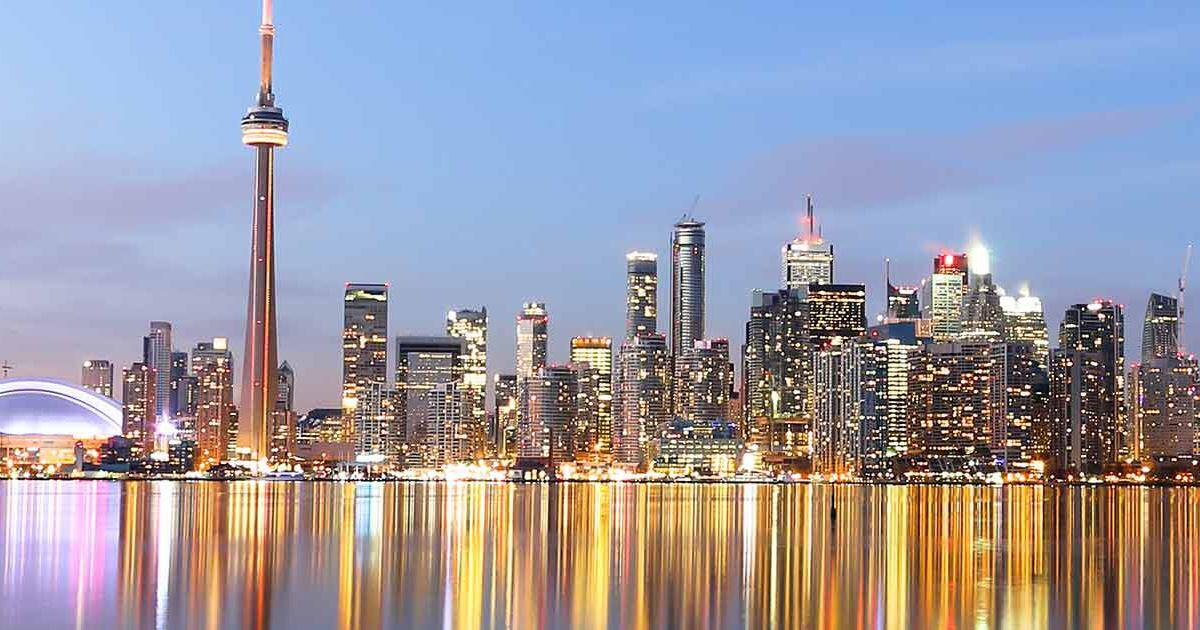

# Capstone Project - The Battle of Neighborhoods

## Introduction/Business Problem

Toronto, the capital of the province of Ontario, is a major Canadian city along Lake Ontario’s northwestern shore. With a recorded population of 2,731,571 in 2016, it is the most populous city in Canada and the fourth most populous city in North America. Toronto is a financial capital of Canada and is a land of opportunity for entrepreneurs. Knowing that Toronto is a multicultural city and a dream of a ‘foodie’, we would like to use Foursquare location data and regional clustering of venue information to determine what might be the ‘best’ neighborhood in Toronto to open a new Greek restaurant.

The purpose of this whole exercise is for submission of the final capstone project for the "IBM Data Science" course on Coursera as well as to determine what neighborhood of Toronto would be the most optimal to open a new Greek Restaurant. Target audience for this analysis would be individuals/entrepreneurs who are planning to open a Greek Restaurant in Toronto and are looking for the optimal neighbourhood to do it.

## Data

1.	List of postal codes of Canada Wiki: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M for access to neighborhood data of Toronto region.
2.	Geographical coordinates of the neighborhoods: http://cocl.us/Geospatial_data for getting the longitude and latitude data for the neighborhoods.
3.	Foursquare database: https://Foursquare.com to be used in order to explore the desired neighborhood data for various restaurant details and access the JSON files. This data shall be utilized to map the Indian restaurants in various locations.

### Using BeautifulSoup package to transform the data in the table on the Wikipedia page into the pandas dataframe.

In [93]:
# import necessary libraries 

!pip install beautifulsoup4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
! pip install folium==0.5.0
import folium # plotting library
!pip install branca==0.3.1 

%matplotlib inline
print('Packages installed')

  Found existing installation: branca 0.4.2
    Uninstalling branca-0.4.2:
      Successfully uninstalled branca-0.4.2
Packages installed


In [94]:
! jupyter trust FinalCapstoneProjectAP.ipynb

Notebook already signed: FinalCapstoneProjectAP.ipynb


In [95]:

req = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M") 

soup = BeautifulSoup(req.content,'lxml') 

table_contents=[]
table = soup.find_all('table')[0]

df = pd.read_html(str(table))

neighborhood=pd.DataFrame(df[0])

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [96]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [97]:
df.drop_duplicates(inplace=True)
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [98]:
print('The DataFrame shape is', df.shape)

The DataFrame shape is (103, 3)


### Using the csv file to create the dataframe.

In [99]:
df_geo_coor = pd.read_csv("./Geospatial_Coordinates.csv")
df_geo_coor.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [100]:
df_toronto = pd.merge(df, df_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [101]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

### Finding all neighborhoods that have the Toronto in it

In [102]:
df_toronto.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [103]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [104]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [105]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

### Credentials

In [106]:
CLIENT_ID = 'RIH1ZWEFN0CM2VIWUN2QXLMEOQBCJPQVCRIJA4W4CBKB3DTM'
CLIENT_SECRET = 'DZZ3NSO30K1BKJ22QOSYQU5MO3UGIAHFYJMUGSG5PTAZQFTY'
VERSION = '20180605'

print('Credentials Stored')

Credentials Stored


In [108]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.6)
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.9).add_to(map_toronto)
map_toronto

### Geting the top 100 venues that are in Lawrence Park within a radius of 500 meters.

In [66]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [67]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [68]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2  Rouge Hill, Port Union, Highland Creek              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                                              Venue  \
0              -79.194353                                            Wendy’s   
1              -79.160497                              Royal Canadian Legion   
2              -79.160497  SEBS Engineering Inc. (Sustainable Energy and ...   
3              -79.188711                                     RBC Royal Bank   
4              -79.188711                                  G & G Electronics   

   Venue Latitude  Venue Longitude              Venue Category  
0       43.807448       -79.199056        Fast Food Restaurant  
1       43.782533       -79.163085                         Bar  
2       43.782371       -79.156820  Construction & Landscaping  
3       43.766790       -79.191151                        Bank  
4       43.765309       -79.191537           Electronics Store

In [69]:
#Lets check how many venues per neighborhood
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            5   
Alderwood, Long Branch                                               6   
Bathurst Manor, Wilson Heights, Downsview North                     21   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   25   
...                                                                ...   
Willowdale South                                                    34   
Willowdale West                                                      5   
Woburn                                                               3   
Woodbine Heights                                                     7   
York Mills West                                                      2   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             5   
Alderwood, Long Branch                                                6   
Bathurst Manor, Wilson Heights, Downsview North                      21   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    25   
...                                                                 ...   
Willowdale South                                                     34   
Willowdale West                                                       5   
Woburn                                                                3   
Woodbine Heights                                                      7   
York Mills West                                                       2   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            5               5   
Alderwood, Long Branch                               6               6   
Bathurst Manor, Wilson Heights, Downsview North     21              21   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   25              25   
...                                                ...             ...   
Willowdale South                                    34              34   
Willowdale West                                      5               5   
Woburn                                               3               3   
Woodbine Heights                                     7               7   
York Mills West                                      2               2   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      5   
Alderwood, Long Branch                                         6   
Bathurst Manor, Wilson Heights, Downsview North               21   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             25   
...                                                          ...   
Willowdale South                                              34   
Willowdale West                                                5   
Woburn                                                         3   
Woodbine Heights                                               7   
York Mills West                                                2   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     5  
Alderwood, Long Branch                                        6 

### How many unique venues are there?

In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques categories.


In [21]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Bar' 'Construction & Landscaping' 'Bank'
 'Electronics Store' 'Restaurant' 'Mexican Restaurant'
 'Rental Car Location' 'Donut Shop' 'Medical Center' 'Intersection'
 'Breakfast Spot' 'Coffee Shop' 'Korean BBQ Restaurant' 'Hakka Restaurant'
 'Caribbean Restaurant' 'Thai Restaurant' 'Athletics & Sports'
 'Gas Station' 'Bakery' 'Fried Chicken Joint' 'Playground' 'Spa'
 'Department Store' 'Chinese Restaurant' 'Hobby Shop' 'Discount Store'
 'Bus Station' 'Ice Cream Shop' 'Bus Line' 'Park' 'Soccer Field' 'Motel'
 'American Restaurant' 'Café' 'General Entertainment' 'Skating Rink'
 'College Stadium' 'Indian Restaurant' 'Vietnamese Restaurant'
 'Light Rail Station' 'Pet Store' 'Sandwich Place'
 'Middle Eastern Restaurant' 'Shopping Mall' 'Smoke Shop' 'Auto Garage'
 'Latin American Restaurant' 'Lounge' 'Clothing Store'
 'Italian Restaurant' 'Noodle House' 'Pizza Place' 'Convenience Store'
 'Pharmacy' 'Grocery Store' 'Golf Course' 'Pool'
 'Mediter

In [22]:
"Greek Restaurant" in toronto_venues['Venue Category'].unique()

True

In [23]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2126, 269)


Neighborhoods  Accessories Store  Adult Boutique  \
0                          Malvern, Rouge                  0               0   
1  Rouge Hill, Port Union, Highland Creek                  0               0   
2  Rouge Hill, Port Union, Highland Creek                  0               0   
3       Guildwood, Morningside, West Hill                  0               0   
4       Guildwood, Morningside, West Hill                  0               0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0        0                   0             0               0                0   
1        0                   0             0               0                0   
2        0                   0             0               0                0   
3        0                   0             0               0                0   
4        0                   0             0               0                0   

   Airport Terminal  American Restaurant  ...  Train Station  \
0                 0                    0  ...              0   
1                 0                    0  ...              0   
2                 0                    0  ...              0   
3                 0                    0  ...              0   
4                 0                    0  ...              0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Warehouse Store  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0                0         0          0            0              0   
1                0         0          0            0              0   
2                0         0          0            0              0   
3                0         0          0            0              0   
4                0         0          0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 269 columns]

In [24]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(99, 269)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0      0.0                 0.0           0.0             0.0   
1             0.0      0.0                 0.0           0.0             0.0   
2             0.0      0.0                 0.0           0.0             0.0   
3             0.0      0.0                 0.0           0.0             0.0   
4             0.0      0.0                 0.0           0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  ...  Train Station  \
0              0.0               0.0                 0.00  ...            0.0   
1              0.0               0.0                 0.00  ...            0.0   
2              0.0               0.0                 0.00  ...            0.0   
3              0.0               0.0                 0.00  ...            0.0   
4              0.0               0.0                 0.04  ...            0.0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                            0.0               0.0                    0.0   
1                            0.0               0.0                    0.0   
2                            0.0               0.0                    0.0   
3                            0.0               0.0                    0.0   
4                            0.0               0.0                    0.0   

   Warehouse Store  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0              0.0       0.0        0.0          0.0            0.0   
1              0.0       0.0        0.0          0.0            0.0   
2              0.0       0.0        0.0          0.0            0.0   
3              0.0       0.0        0.0          0.0            0.0   
4              0.0       0.0        0.0          0.0            0.0   

   Yoga Studio  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 269 columns]

In [25]:
ita = to_grouped[["Neighborhoods","Greek Restaurant"]]
ita.head() #.head() shows the first five rows only

Neighborhoods  Greek Restaurant
0                                        Agincourt              0.00
1                           Alderwood, Long Branch              0.00
2  Bathurst Manor, Wilson Heights, Downsview North              0.00
3                                  Bayview Village              0.00
4                Bedford Park, Lawrence Manor East              0.04

In [26]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

### Cluster the neighborhoods

In [27]:
#We will use k-means clustering. But first we will find the best K using the Elbow Point method.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [28]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 4, 3, 0, 0, 0, 0], dtype=int32)

In [29]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [30]:
scores = [get_inertia(x) for x in range(2, 21)]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/cond

Text(0, 0.5, 'Error')

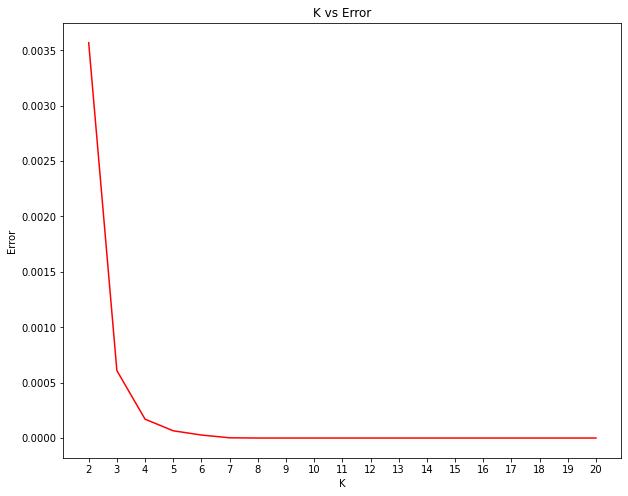

In [31]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [32]:
! pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [33]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/cond

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 2, 0, 0, 0, 0], dtype=int32)

In [35]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [36]:
to_merged.head()

Neighborhood  Greek Restaurant  \
0                                        Agincourt              0.00   
1                           Alderwood, Long Branch              0.00   
2  Bathurst Manor, Wilson Heights, Downsview North              0.00   
3                                  Bayview Village              0.00   
4                Bedford Park, Lawrence Manor East              0.04   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               3

In [37]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2126, 9)


Neighborhood  Greek Restaurant  Cluster Labels  Neighborhood Latitude  \
0    Agincourt               0.0               0                43.7942   
0    Agincourt               0.0               0                43.7942   
0    Agincourt               0.0               0                43.7942   
0    Agincourt               0.0               0                43.7942   
0    Agincourt               0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.259714             Clothing Store  
0       -79.267989               Skating Rink

In [38]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2126, 9)


Neighborhood  Greek Restaurant  \
0                                  Agincourt          0.000000   
59  North Park, Maple Leaf Park, Upwood Park          0.000000   
59  North Park, Maple Leaf Park, Upwood Park          0.000000   
59  North Park, Maple Leaf Park, Upwood Park          0.000000   
59  North Park, Maple Leaf Park, Upwood Park          0.000000   
..                                       ...               ...   
4          Bedford Park, Lawrence Manor East          0.040000   
4          Bedford Park, Lawrence Manor East          0.040000   
4          Bedford Park, Lawrence Manor East          0.040000   
4          Bedford Park, Lawrence Manor East          0.040000   
18                                Davisville          0.030303   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                0              43.794200              -79.262029   
59               0              43.713756              -79.490074   
59               0              43.713756              -79.490074   
59               0              43.713756              -79.490074   
59               0              43.713756              -79.490074   
..             ...                    ...                     ...   
4                3              43.733283              -79.419750   
4                3              43.733283              -79.419750   
4                3              43.733283              -79.419750   
4                3              43.733283              -79.419750   
18               3              43.704324              -79.388790   

                          Venue  Venue Latitude  Venue Longitude  \
0   Panagio's Breakfast & Lunch       43.792370       -79.260203   
59                  Mika's Trim       43.714068       -79.496113   
59              Maple leaf park       43.716188       -79.493531   
59                       Sporty       43.716503       -79.489838   
59                Rustic Bakery       43.715414       -79.490300   
..                          ...             ...              ...   
4             Bruno's Fine Food       43.736642       -79.419870   
4          Safari Bar and Grill       43.729051       -79.418109   
4                    McDonald's       43.732540       -79.419796   
4                          LCBO       43.731065       -79.419237   
18                   Second Cup       43.704344       -79.388659   

                Venue Category  
0               Breakfast Spot  
59  Construction & Landscaping  
59                        Park  
59            Basketball Court  
59                      Bakery  
..                         ...  
4                      Butcher  
4          American Restaurant  
4         Fast Food Restaurant  
4                 Liquor Store  
18                 Coffee Shop  

[2126 rows x 9 columns]

In [39]:
to_merged['Venue Category'].value_counts()['Greek Restaurant']

15

### We see that there are a total of 15 locations with Greek Restaurants in Toronto, therefore, we will create a new dataframe with the Neighborhood and Greek Restaurant

In [40]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
map_clusters

In [41]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Greek Restaurant  \
0                                        Agincourt              0.00   
1                           Alderwood, Long Branch              0.00   
2  Bathurst Manor, Wilson Heights, Downsview North              0.00   
3                                  Bayview Village              0.00   
4                Bedford Park, Lawrence Manor East              0.04   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               3

In [42]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [43]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    91
2     5
3     2
1     1
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster

In [44]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                            Neighborhood
0  Scarborough                          Malvern, Rouge
1  Scarborough  Rouge Hill, Port Union, Highland Creek
2  Scarborough       Guildwood, Morningside, West Hill
3  Scarborough                                  Woburn
4  Scarborough                               Cedarbrae

### Cluster 1

In [45]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

Borough                                       Neighborhood  \
0             Scarborough                                     Malvern, Rouge   
1             Scarborough             Rouge Hill, Port Union, Highland Creek   
2             Scarborough             Rouge Hill, Port Union, Highland Creek   
3             Scarborough                  Guildwood, Morningside, West Hill   
4             Scarborough                  Guildwood, Morningside, West Hill   
...                   ...                                                ...   
1654            Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
1655            Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
1656  Etobicoke Northwest  Clairville, Humberwood, Woodbine Downs, West H...   
1657  Etobicoke Northwest  Clairville, Humberwood, Woodbine Downs, West H...   
1658  Etobicoke Northwest  Clairville, Humberwood, Woodbine Downs, West H...   

      Greek Restaurant  Cluster Labels  Neighborhood Latitude  \
0                  0.0               0              43.806686   
1                  0.0               0              43.784535   
2                  0.0               0              43.784535   
3                  0.0               0              43.763573   
4                  0.0               0              43.763573   
...                ...             ...                    ...   
1654               0.0               0              43.739416   
1655               0.0               0              43.739416   
1656               0.0               0              43.706748   
1657               0.0               0              43.706748   
1658               0.0               0              43.706748   

      Neighborhood Longitude  \
0                 -79.194353   
1                 -79.160497   
2                 -79.160497   
3                 -79.188711   
4                 -79.188711   
...                      ...   
1654              -79.588437   
1655              -79.588437   
1656              -79.594054   
1657              -79.594054   
1658              -79.594054   

                                                  Venue  Venue Latitude  \
0                                               Wendy’s       43.807448   
1     SEBS Engineering Inc. (Sustainable Energy and ...       43.782371   
2                                 Royal Canadian Legion       43.782533   
3                                              Eggsmart       43.767800   
4                                 Woburn Medical Centre       43.766631   
...                                                 ...             ...   
1654                                 Shoppers Drug Mart       43.741685   
1655                                     Sunny Foodmart       43.741840   
1656                                          PC Garden       43.706539   
1657                                      Saand Rexdale       43.705072   
1658                                 Economy Rent A Car       43.708471   

      Venue Longitude              Venue Category  
0          -79.199056        Fast Food Restaurant  
1          -79.156820  Construction & Landscaping  
2          -79.163085                         Bar  
3          -79.190466              Breakfast Spot  
4          -79.192286              Medical Center  
...               ...                         ...  
1654       -79.584487                    Pharmacy  
1655       -79.590561               Grocery Store  
1656       -79.599359               Garden Center  
1657       -79.598725                   Drugstore  
1658       -79.589943         Rental Car Location  

[1659 rows x 10 columns]

### Cluster 2

In [46]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

Borough                  Neighborhood  Greek Restaurant  \
0   East Toronto  The Danforth West, Riverdale          0.190476   
1   East Toronto  The Danforth West, Riverdale          0.190476   
2   East Toronto  The Danforth West, Riverdale          0.190476   
3   East Toronto  The Danforth West, Riverdale          0.190476   
4   East Toronto  The Danforth West, Riverdale          0.190476   
5   East Toronto  The Danforth West, Riverdale          0.190476   
6   East Toronto  The Danforth West, Riverdale          0.190476   
7   East Toronto  The Danforth West, Riverdale          0.190476   
8   East Toronto  The Danforth West, Riverdale          0.190476   
9   East Toronto  The Danforth West, Riverdale          0.190476   
10  East Toronto  The Danforth West, Riverdale          0.190476   
11  East Toronto  The Danforth West, Riverdale          0.190476   
12  East Toronto  The Danforth West, Riverdale          0.190476   
13  East Toronto  The Danforth West, Riverdale          0.190476   
14  East Toronto  The Danforth West, Riverdale          0.190476   
15  East Toronto  The Danforth West, Riverdale          0.190476   
16  East Toronto  The Danforth West, Riverdale          0.190476   
17  East Toronto  The Danforth West, Riverdale          0.190476   
18  East Toronto  The Danforth West, Riverdale          0.190476   
19  East Toronto  The Danforth West, Riverdale          0.190476   
20  East Toronto  The Danforth West, Riverdale          0.190476   
21  East Toronto  The Danforth West, Riverdale          0.190476   
22  East Toronto  The Danforth West, Riverdale          0.190476   
23  East Toronto  The Danforth West, Riverdale          0.190476   
24  East Toronto  The Danforth West, Riverdale          0.190476   
25  East Toronto  The Danforth West, Riverdale          0.190476   
26  East Toronto  The Danforth West, Riverdale          0.190476   
27  East Toronto  The Danforth West, Riverdale          0.190476   
28  East Toronto  The Danforth West, Riverdale          0.190476   
29  East Toronto  The Danforth West, Riverdale          0.190476   
30  East Toronto  The Danforth West, Riverdale          0.190476   
31  East Toronto  The Danforth West, Riverdale          0.190476   
32  East Toronto  The Danforth West, Riverdale          0.190476   
33  East Toronto  The Danforth West, Riverdale          0.190476   
34  East Toronto  The Danforth West, Riverdale          0.190476   
35  East Toronto  The Danforth West, Riverdale          0.190476   
36  East Toronto  The Danforth West, Riverdale          0.190476   
37  East Toronto  The Danforth West, Riverdale          0.190476   
38  East Toronto  The Danforth West, Riverdale          0.190476   
39  East Toronto  The Danforth West, Riverdale          0.190476   
40  East Toronto  The Danforth West, Riverdale          0.190476   
41  East Toronto  The Danforth West, Riverdale          0.190476   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                1              43.679557              -79.352188   
1                1              43.679557              -79.352188   
2                1              43.679557              -79.352188   
3                1              43.679557              -79.352188   
4                1              43.679557              -79.352188   
5                1              43.679557              -79.352188   
6                1              43.679557              -79.352188   
7                1              43.679557              -79.352188   
8                1              43.679557              -79.352188   
9                1              43.679557              -79.352188   
10               1              43.679557              -79.352188   
11               1              43.679557              -79.352188   
12               1              43.679557              -79.352188   
13               1              43.679557              -79.352188   
14               1              43.679557        

In [47]:
df_cluster2.sort_values(["Greek Restaurant"], ascending=False)

Borough                  Neighborhood  Greek Restaurant  \
0   East Toronto  The Danforth West, Riverdale          0.190476   
31  East Toronto  The Danforth West, Riverdale          0.190476   
23  East Toronto  The Danforth West, Riverdale          0.190476   
24  East Toronto  The Danforth West, Riverdale          0.190476   
25  East Toronto  The Danforth West, Riverdale          0.190476   
26  East Toronto  The Danforth West, Riverdale          0.190476   
27  East Toronto  The Danforth West, Riverdale          0.190476   
28  East Toronto  The Danforth West, Riverdale          0.190476   
29  East Toronto  The Danforth West, Riverdale          0.190476   
30  East Toronto  The Danforth West, Riverdale          0.190476   
32  East Toronto  The Danforth West, Riverdale          0.190476   
1   East Toronto  The Danforth West, Riverdale          0.190476   
33  East Toronto  The Danforth West, Riverdale          0.190476   
34  East Toronto  The Danforth West, Riverdale          0.190476   
35  East Toronto  The Danforth West, Riverdale          0.190476   
36  East Toronto  The Danforth West, Riverdale          0.190476   
37  East Toronto  The Danforth West, Riverdale          0.190476   
38  East Toronto  The Danforth West, Riverdale          0.190476   
39  East Toronto  The Danforth West, Riverdale          0.190476   
40  East Toronto  The Danforth West, Riverdale          0.190476   
22  East Toronto  The Danforth West, Riverdale          0.190476   
21  East Toronto  The Danforth West, Riverdale          0.190476   
20  East Toronto  The Danforth West, Riverdale          0.190476   
19  East Toronto  The Danforth West, Riverdale          0.190476   
2   East Toronto  The Danforth West, Riverdale          0.190476   
3   East Toronto  The Danforth West, Riverdale          0.190476   
4   East Toronto  The Danforth West, Riverdale          0.190476   
5   East Toronto  The Danforth West, Riverdale          0.190476   
6   East Toronto  The Danforth West, Riverdale          0.190476   
7   East Toronto  The Danforth West, Riverdale          0.190476   
8   East Toronto  The Danforth West, Riverdale          0.190476   
9   East Toronto  The Danforth West, Riverdale          0.190476   
10  East Toronto  The Danforth West, Riverdale          0.190476   
11  East Toronto  The Danforth West, Riverdale          0.190476   
12  East Toronto  The Danforth West, Riverdale          0.190476   
13  East Toronto  The Danforth West, Riverdale          0.190476   
14  East Toronto  The Danforth West, Riverdale          0.190476   
15  East Toronto  The Danforth West, Riverdale          0.190476   
16  East Toronto  The Danforth West, Riverdale          0.190476   
17  East Toronto  The Danforth West, Riverdale          0.190476   
18  East Toronto  The Danforth West, Riverdale          0.190476   
41  East Toronto  The Danforth West, Riverdale          0.190476   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                1              43.679557              -79.352188   
31               1              43.679557              -79.352188   
23               1              43.679557              -79.352188   
24               1              43.679557              -79.352188   
25               1              43.679557              -79.352188   
26               1              43.679557              -79.352188   
27               1              43.679557              -79.352188   
28               1              43.679557              -79.352188   
29               1              43.679557              -79.352188   
30               1              43.679557              -79.352188   
32               1              43.679557              -79.352188   
1                1              43.679557              -79.352188   
33               1              43.679557              -79.352188   
34               1              43.679557              -79.352188   
35               1              43.679557        

In [48]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Greek Restaurant']

8

### Cluster 3

In [49]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                  Neighborhood  Greek Restaurant  \
0      North York  Fairview, Henry Farm, Oriole          0.015152   
1      North York  Fairview, Henry Farm, Oriole          0.015152   
2      North York  Fairview, Henry Farm, Oriole          0.015152   
3      North York  Fairview, Henry Farm, Oriole          0.015152   
4      North York  Fairview, Henry Farm, Oriole          0.015152   
..            ...                           ...               ...   
362  West Toronto      Little Portugal, Trinity          0.023256   
363  West Toronto      Little Portugal, Trinity          0.023256   
364  West Toronto      Little Portugal, Trinity          0.023256   
365  West Toronto      Little Portugal, Trinity          0.023256   
366  West Toronto      Little Portugal, Trinity          0.023256   

     Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                 2              43.778517              -79.346556   
1                 2              43.778517              -79.346556   
2                 2              43.778517              -79.346556   
3                 2              43.778517              -79.346556   
4                 2              43.778517              -79.346556   
..              ...                    ...                     ...   
362               2              43.647927              -79.419750   
363               2              43.647927              -79.419750   
364               2              43.647927              -79.419750   
365               2              43.647927              -79.419750   
366               2              43.647927              -79.419750   

                            Venue  Venue Latitude  Venue Longitude  \
0                        Old Navy       43.777990       -79.344091   
1        Fairview Library Theatre       43.779018       -79.346526   
2                     Oriole Park       43.780817       -79.351327   
3               Bourbon St. Grill       43.778276       -79.343241   
4                          Z•teca       43.777217       -79.344401   
..                            ...             ...              ...   
362                      OddSeoul       43.646192       -79.419601   
363                 Foxley Bistro       43.648643       -79.420495   
364  Bang Bang Ice Cream & Bakery       43.646246       -79.419553   
365             Pizzeria Libretto       43.648979       -79.420604   
366             Bellwoods Brewery       43.647097       -79.419955   

           Venue Category  
0          Clothing Store  
1                 Theater  
2          Baseball Field  
3    Fast Food Restaurant  
4           Burrito Place  
..                    ...  
362     Korean Restaurant  
363      Asian Restaurant  
364        Ice Cream Shop  
365           Pizza Place  
366               Brewery  

[367 rows x 10 columns]

### Cluster 4

In [50]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                       Neighborhood  Greek Restaurant  \
0   Central Toronto                         Davisville          0.030303   
1   Central Toronto                         Davisville          0.030303   
2   Central Toronto                         Davisville          0.030303   
3   Central Toronto                         Davisville          0.030303   
4   Central Toronto                         Davisville          0.030303   
5   Central Toronto                         Davisville          0.030303   
6   Central Toronto                         Davisville          0.030303   
7   Central Toronto                         Davisville          0.030303   
8   Central Toronto                         Davisville          0.030303   
9   Central Toronto                         Davisville          0.030303   
10  Central Toronto                         Davisville          0.030303   
11  Central Toronto                         Davisville          0.030303   
12  Central Toronto                         Davisville          0.030303   
13  Central Toronto                         Davisville          0.030303   
14  Central Toronto                         Davisville          0.030303   
15  Central Toronto                         Davisville          0.030303   
16  Central Toronto                         Davisville          0.030303   
17  Central Toronto                         Davisville          0.030303   
18  Central Toronto                         Davisville          0.030303   
19  Central Toronto                         Davisville          0.030303   
20  Central Toronto                         Davisville          0.030303   
21  Central Toronto                         Davisville          0.030303   
22  Central Toronto                         Davisville          0.030303   
23  Central Toronto                         Davisville          0.030303   
24  Central Toronto                         Davisville          0.030303   
25  Central Toronto                         Davisville          0.030303   
26  Central Toronto                         Davisville          0.030303   
27  Central Toronto                         Davisville          0.030303   
28  Central Toronto                         Davisville          0.030303   
29  Central Toronto                         Davisville          0.030303   
30  Central Toronto                         Davisville          0.030303   
31  Central Toronto                         Davisville          0.030303   
32  Central Toronto                         Davisville          0.030303   
33       North York  Bedford Park, Lawrence Manor East          0.040000   
34       North York  Bedford Park, Lawrence Manor East          0.040000   
35       North York  Bedford Park, Lawrence Manor East          0.040000   
36       North York  Bedford Park, Lawrence Manor East          0.040000   
37       North York  Bedford Park, Lawrence Manor East          0.040000   
38       North York  Bedford Park, Lawrence Manor East          0.040000   
39       North York  Bedford Park, Lawrence Manor East          0.040000   
40       North York  Bedford Park, Lawrence Manor East          0.040000   
41       North York  Bedford Park, Lawrence Manor East          0.040000   
42       North York  Bedford Park, Lawrence Manor East          0.040000   
43       North York  Bedford Park, Lawrence Manor East          0.040000   
44       North York  Bedford Park, Lawrence Manor East          0.040000   
45       North York  Bedford Park, Lawrence Manor East          0.040000   
46       North York  Bedford Park, Lawrence Manor East          0.040000   
47       North York  Bedford Park, Lawrence Manor East          0.040000   
48       North York  Bedford Park, Lawrence Manor East          0.040000   
49       North York  Bedford Park, Lawrence Manor East          0.040000   
50       North York  Bedford Park, Lawrence Manor East          0.040000   
51       North York  Bedford Park, Lawrence Manor East      

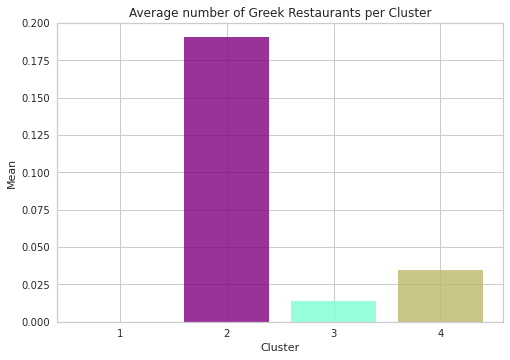

In [51]:
clusters_mean = [df_cluster1['Greek Restaurant'].mean(),df_cluster2['Greek Restaurant'].mean(),df_cluster3['Greek Restaurant'].mean(),
                 df_cluster4['Greek Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Greek Restaurants per Cluster')

plt.show()

## Observations

Most of the Greek Restaurants are in cluster 2 represented by the purple clusters, that would probably mean that opening a Greek Restaurant in The Danforth West and Riverdale (East Toronto) wouldn't be a great idea, since there is huge competition. 

Even though there is a huge amount of Neighborhoods in cluster 1, there are no Greek Restaurants at all, so it would be one of the optimal neighborhoods to consider when planning to open a new Greek Restaurant. 

We also see that the North York area (cluster 3) has the second last average of Greek Restaurants. Looking at the nearby venues, Fairview, Henry Farm, and Oriole, would be a great opportunity to open up a new Greek Restaurant.

We wouldn't suggest opening a Greek Restaurant in Central Toronto, as there is also a lot of competition. 

This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations with little to no competition.